`statsmodels` ARIMAX example. See: https://pyflux.readthedocs.io/en/latest/arimax.html



## Setting up our example

In [1]:
# set up Python
import numpy as np
import pandas as pd
import statsmodels.api as sm
import plotnine
from plotnine import *
from nested_model_fns import plot_model_quality

# set plot size
plotnine.options.figure_size = (16, 8)

In [2]:
d_train = pd.read_csv("d_train.csv")
d_test = pd.read_csv("d_test.csv")

In [3]:
d_train

,time_tick,z_0,x_0,y,ext_regressors
0,0,0,0,52.873288,"z_0: 0, x_0: 0"
1,1,0,1,69.679317,"z_0: 0, x_0: 1"
2,2,0,0,55.003274,"z_0: 0, x_0: 0"
3,3,0,0,56.025156,"z_0: 0, x_0: 0"
4,4,1,0,70.415189,"z_0: 1, x_0: 0"
...,...,...,...,...,...
975,975,0,0,0.000000,"z_0: 0, x_0: 0"
976,976,0,0,0.000000,"z_0: 0, x_0: 0"
977,977,0,0,2.562078,"z_0: 0, x_0: 0"
978,978,0,1,20.391449,"z_0: 0, x_0: 1"


In [4]:
model3 = sm.tsa.ARIMA(
    endog=d_train['y'],
    exog=d_train[['z_0', 'x_0']],
    order=[2, 0, 2],
)
fit3 = model3.fit()
print(fit3.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  980
Model:                 ARIMA(2, 0, 2)   Log Likelihood               -2437.453
Date:                Thu, 24 Oct 2024   AIC                           4890.905
Time:                        21:20:42   BIC                           4930.005
Sample:                             0   HQIC                          4905.780
                                - 980                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         52.5444      2.258     23.267      0.000      48.118      56.971
z_0            1.4287      0.161      8.848      0.000       1.112       1.745
x_0           16.0278      0.113    142.077      0.0

In [5]:
# https://www.statsmodels.org/stable/generated/statsmodels.tsa.arima.model.ARIMAResults.predict.html
d_test["statsmodels ARIMA (external regressors)"] = np.array(
    fit3.predict(
        start=d_train.shape[0],
        end=d_train.shape[0] + d_test.shape[0] - 1,
        exog=d_test[['z_0', 'x_0']],
        )
)

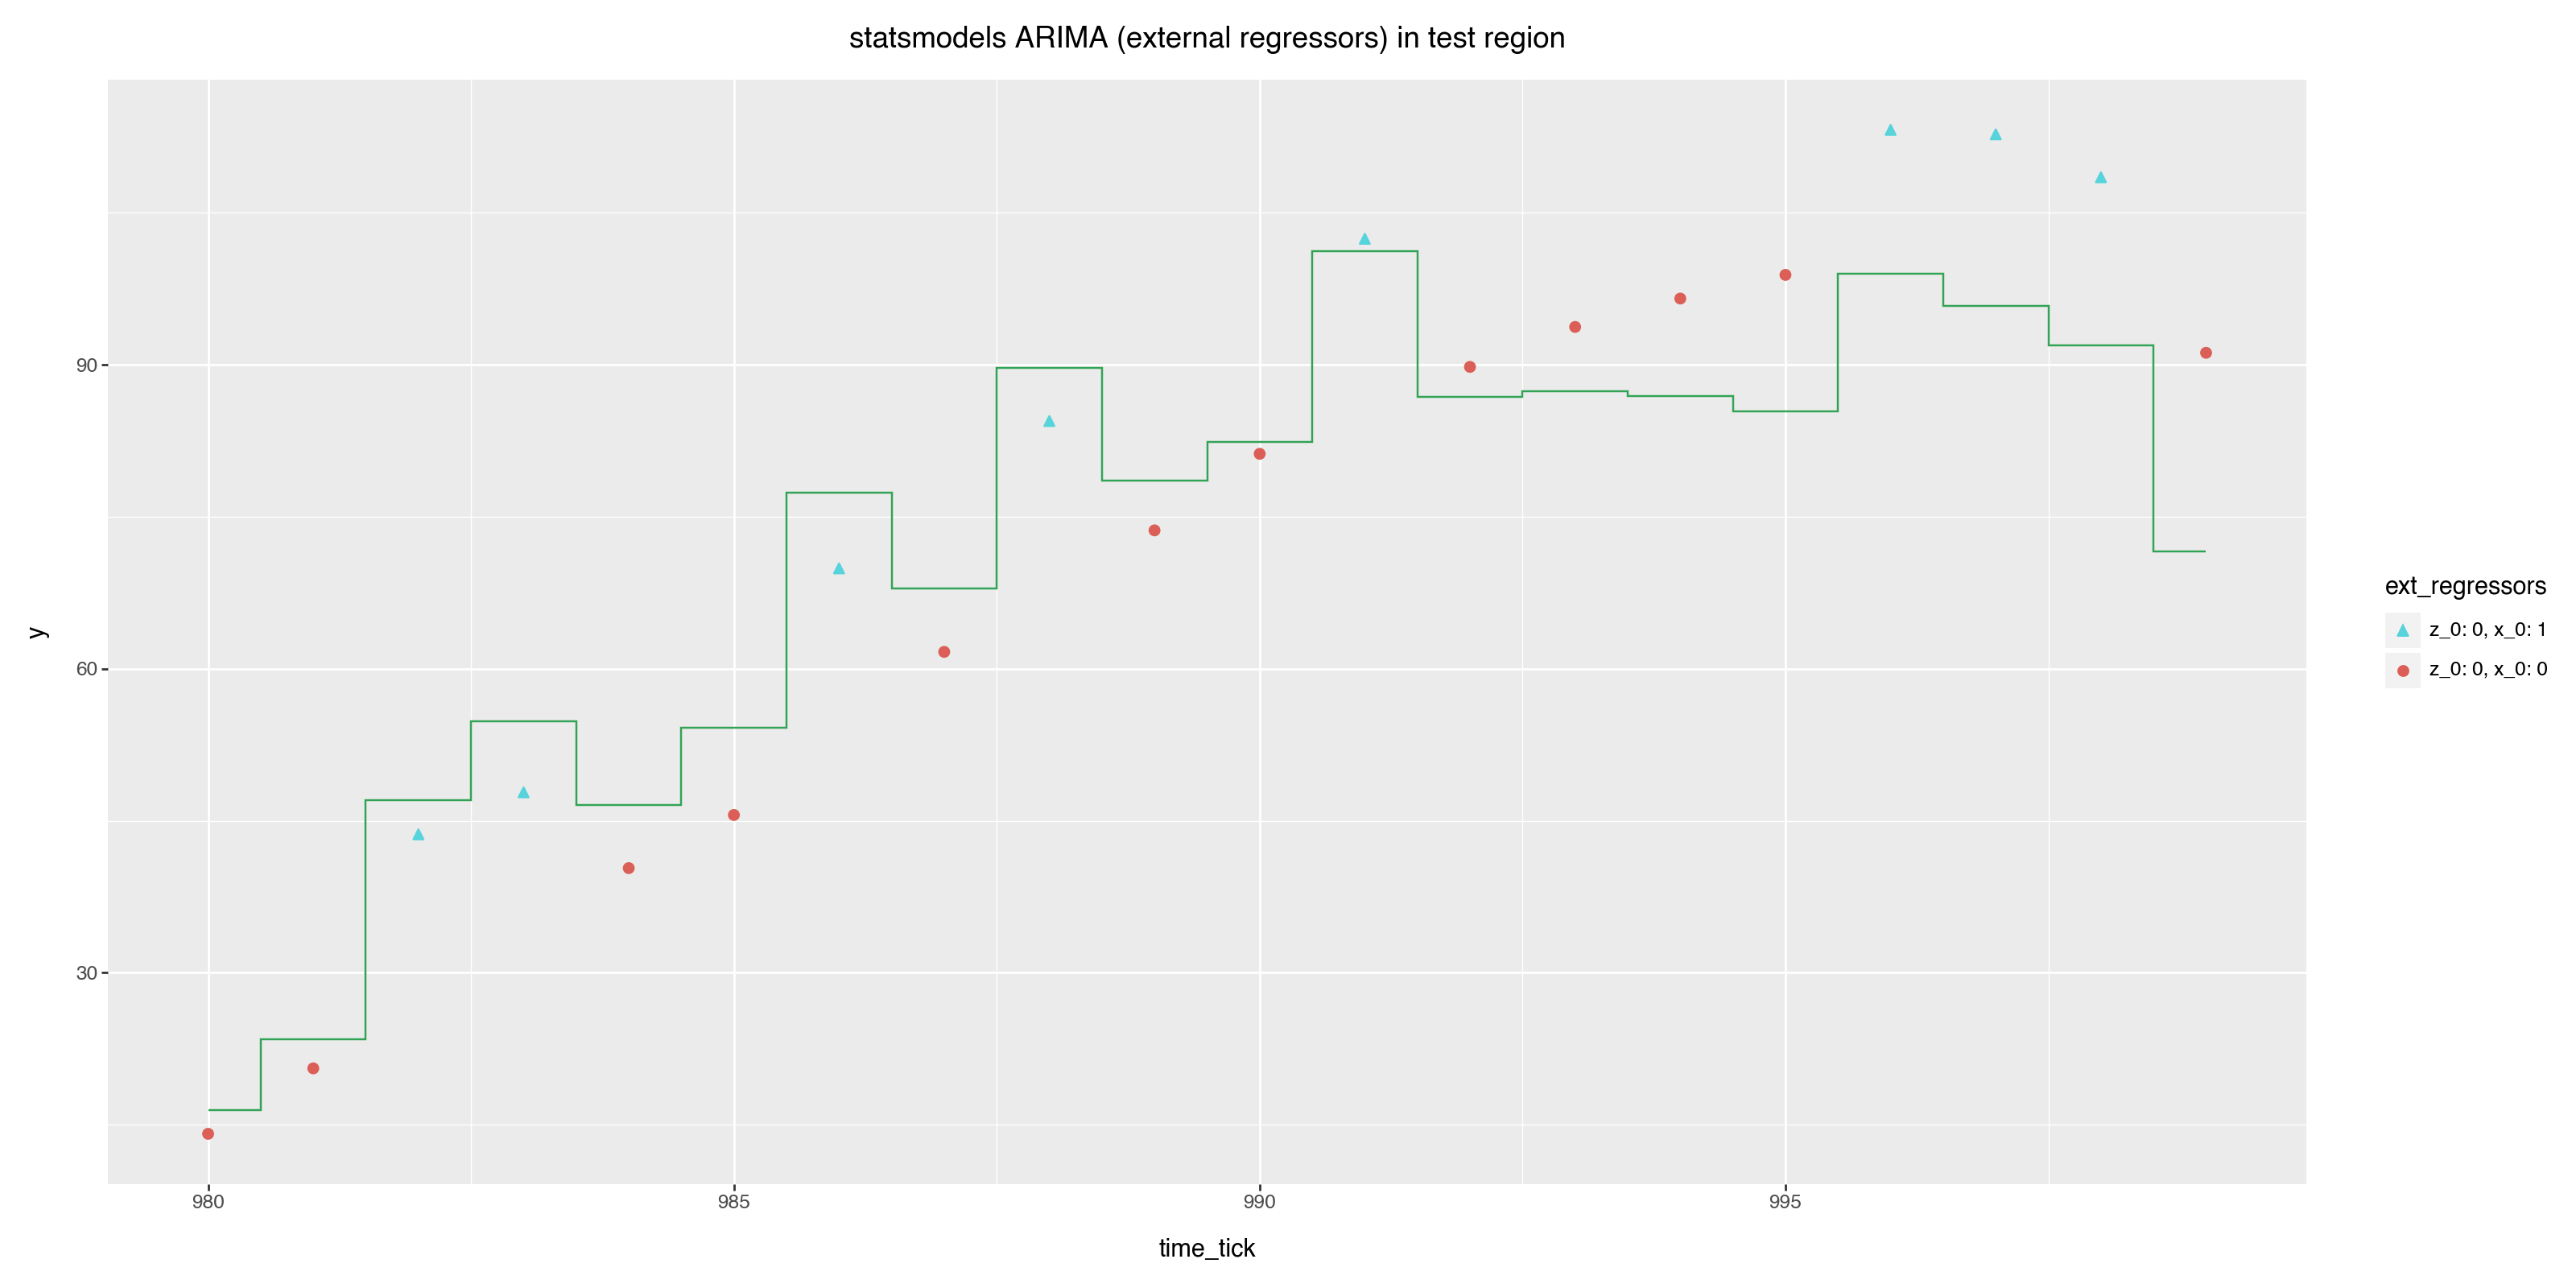

In [6]:
(
    ggplot(
        data=d_test.loc[d_test.notna().all(axis="columns"), :],
        mapping=aes(x="time_tick"),
    )
    + geom_point(
        aes(y="y", shape="ext_regressors", color="ext_regressors"),
        size=2,
    )
    + geom_step(
        aes(y="statsmodels ARIMA (external regressors)"),
        color="#31a354",
        direction="mid",
    )
    + guides(shape=guide_legend(reverse=True))
    + ggtitle("statsmodels ARIMA (external regressors) in test region")
)

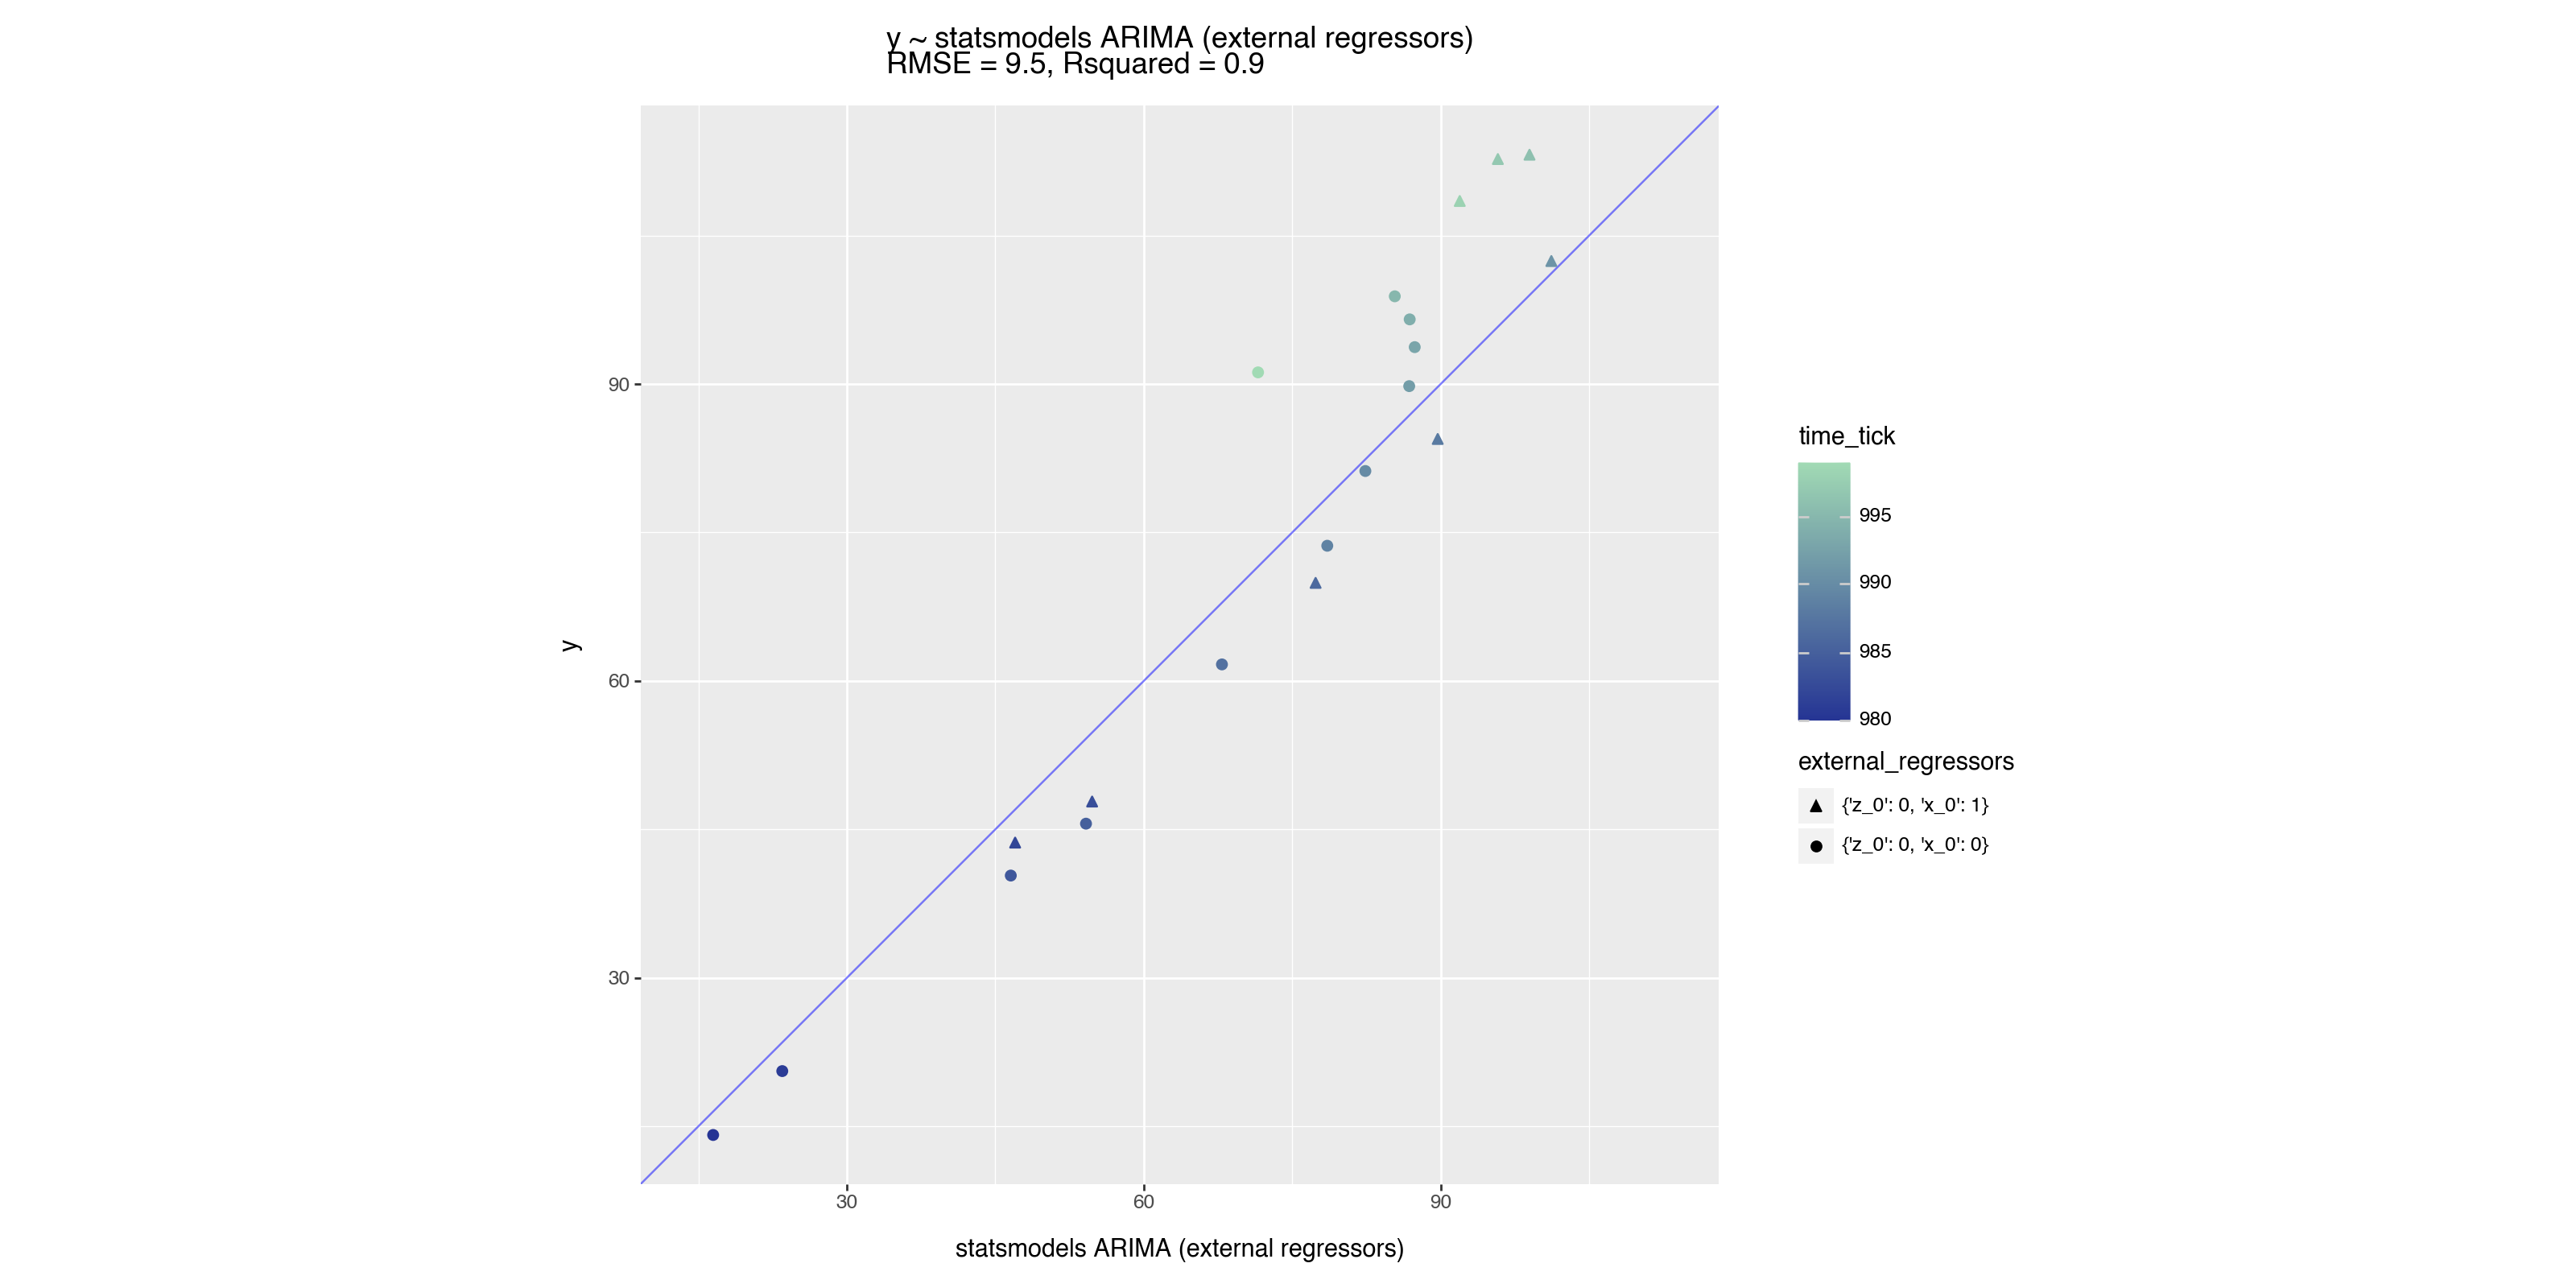

In [7]:
plot_model_quality(
    d_test.loc[
        pd.isnull(d_test["statsmodels ARIMA (external regressors)"]) == False, :
    ],
    result_name="statsmodels ARIMA (external regressors)",
    external_regressors=["z_0", "x_0"],
)